In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Basics of Hypothesis Testing

A hypothesis test can offer support for your data design and model, and it can help formally refute another understanding of the world. There are four basic steps to hypothesis testing:

1. Set up: You have your data, and you want to test whether a particular model is reasonably consistent with the data. So, you specify a test statistic, such as the average value, fraction of zeros in the sample, fitted regression coefficient, etc. You are interested in comparing your data's statistic to what might have been produced under the model.

1. Model: Spell out the model you want to test. This model is a data generation mechanism, and often includes an assumption about, say, the population mean, the chance of a 0 in the sample, the regression coefficient, etc. You are interested in the distribution of the summary statistic under this model. The model is referred to as the Null hypothesis, and the sampling distribution of the statistic is called the null distribution.

3. Compute: How likely, according to the model in Step 2, is it to get a summary statistic at least as extreme as what you actually got in Step 1?  In formal inference, this probability is called the p-value. There are three general approaches to computing p-values, brute force, mathematical theory, and simulation.  
    1. Brute force: List all the samples, compute values of the test statistic for each sample, and count.
    1. Mathematical theory:  Find a shortcut by applying mathematical ideas (e.g., the theory of permutations and combinations) to the structure of the set of samples in the null model.
    1. Simulation:  Use a computer to generate a large number of random samples, and estimate the p-value using the fraction of samples that give a value of the test statistic at least as extreme as the observed value.
  
4. Interpret: The p-value is used as a measure of surprise.  If the model that you spelled out in Step 2 is believable, how surprised should you be to get the data (and summary statistic) that you actually got?  A moderate sized p-value means that the observed value of the test statistic is pretty much what you would expect to get for data generated by the null model.  A tiny p-value raises doubts about the null model: If the model is correct (or approximately correct), then it would be very unusual to get such an extreme value of the test statistic for data generated by the model.  In other words, either the null model is wrong, or else a very unlikely outcome has occurred. Statistical logic says to conclude that the pattern is real, that is, more than just coincidence.  It is then up to you to explain why the data generation process led to such an unusual value. This is when a careful examination of the scope is important. 

Let's make this process more concrete with an example. 

## The Effect of Informal Award on Wikipedia Contributors 

Recall the Wikipedia example from {numref}`Chapter %s <ch:data_scope>`, where randomly selected set of 200 top contributors chosen from among  the top 1\% contributors who were active in the past 30 days on the English-language Wikipedia and who had never receive an informal  "barnstart" award from another contributor.  The 200 contributors were divided at random into two groups of 100, and each contributor in one group was awarded a barnstar, while no one in the other group was given an award. All 200 the contributors were followed for 90 days and their activity on Wikipedia recorded. 

It has been conjectured that informal awards have a reinforcing effect on volunteer work, and this experiment was designed to formally study this conjecture. We will carry out three different tests of this hypothesis, each using a different feature that we observe in our exploration of the data. We begin by reading the data into data frame and exploring it.

In [119]:
wiki = pd.read_csv("data/Wikipedia.csv")

In [127]:
wiki.describe()[3:]

,experiment,posttreatmentproductivity
min,0.0,0.0
25%,0.0,57.5
50%,0.5,250.5
75%,1.0,608.0
max,1.0,2344.0


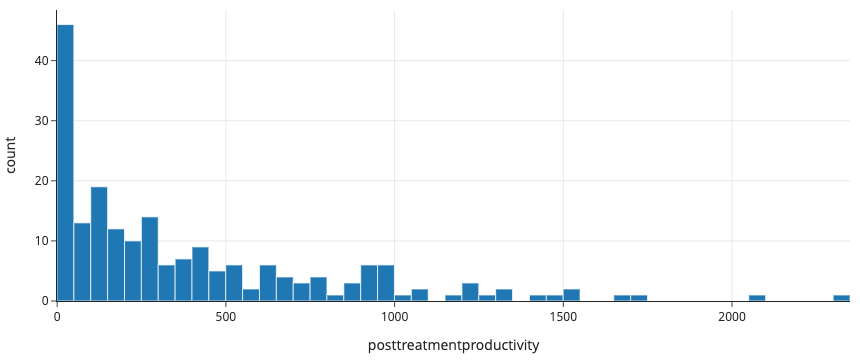

In [6]:
fig = px.histogram(wiki, x='posttreatmentproductivity', nbins=50,
                      width=350, height=250)

fig

The histogram of the productivity of the 200 subjects after half of them received an informal award is highly skewed, with a spike near zero. Let's compare the median productivity for the two groups.

In [41]:
print('Median productivity:', wiki.median()[1], 
      '\nMedian productivity in control group: ', control.median()[1],
      '\nMedian productivity in treatment group: ', treatment.median()[1])

Median productivity: 250.5 
Median productivity in control group:  157.5 
Median productivity me in treatment group:  369.5


The medians are quite different. Let's make a finer comparison of the  control and treatment groups with a quantile-quantile plot (see {numref}`Chapter %s <ch:viz>`). Since the distribution is highly skewed, we have plotted the quantiles on a log scale. And, to handle problems with taking a logarithm of zero, we added one to all the data values. This addition has little impact on the quantiles and distributions since they range from 0 to 2344.

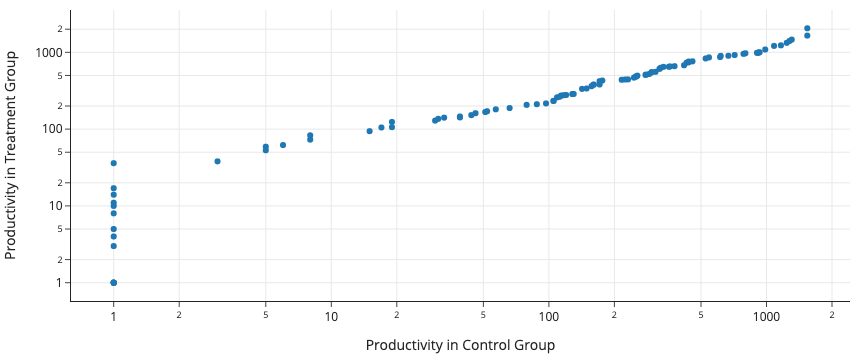

In [46]:
control = wiki.query('experiment == 0')
treatment = wiki.query('experiment == 1')
percs = np.arange(1, 100, 1)
percCon = 1 + np.percentile(control['posttreatmentproductivity'], percs, interpolation='lower')
percTrt = 1 + np.percentile(treatment['posttreatmentproductivity'], percs, interpolation='lower')
perc_wiki = pd.DataFrame({'percentile': percs, 'control': percCon, 'treatment': percTrt})

fig = px.scatter(perc_wiki, x='control', y='treatment', log_x=True, log_y=True, width=500, height=350,
                 labels={'control': 'Productivity in Control Group',
                         'treatment': 'Productivity in Treatment Group'})
 
fig

With one glaring exception, the quantiles of the two distributions roughly follow a line, which indicates that the distributions are similar in shape. The exception is the number of ones in the first several quantiles for the control group. Let's compare the count of zeros in the two groups (remember we added 1 to all of the values before finding the quantiles).  

In [45]:
countAll = wiki['posttreatmentproductivity'].value_counts()[0]
countA = control['posttreatmentproductivity'].value_counts()[0]
countB = treatment['posttreatmentproductivity'].value_counts()[0]
print('Count of 0-productive members: ', countAll,
      '\nCount in control group: ', countA,
      '\nCount in treatment group: ', countB)

Count of no-productivity members:  19 
Count in control group:  14 
Count in treatment group:  5


There are quite a few more zeros in the control group compared to treatment. 
Let's start with the simplest test that is based on the proportion of zeros in the two groups.

## A test for proportions

Statistic: Proportion of zeros. 

More specifically, the Null hypothesis is that informal awards have *no* effect on productivity, and any difference in post-treatment productivity is just due to the random assignment of contributors to the two groups.

Under the null, the proportion of zeros in the treatment and control groups is the same, and any observed difference is due to the random variation in assignment to treatment/control group. 

In {numref}`Chapter %s <ch:theory_design>` 

For each of these test statistics, we will compute the chance of observing a difference between the two groups that is at least the size of what we found in our data. 


In [47]:
sim0s = np.random.hypergeometric(ngood=19, nbad=181, 
                                 nsample=100, size=100000)

Text(0.5, 0, 'Count of 0-productivity Cases in the Treatment Group')

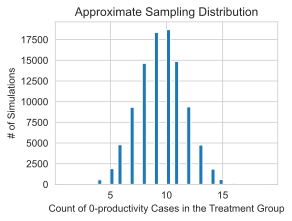

In [52]:
plt.hist(sim0s, bins=50)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Count of 0-productivity Cases in the Treatment Group')

In [56]:
(sim0s <= 5).sum() / 100000

0.02594

## A test for a difference in medians

Statistic: Median productivity. Under the null, we expect the treatment to have no effect and each contributor's productivity would be unaffected by their receipt of the award so the median productivity for top contributors would be unchanged by the receipt of an informal award. Any difference in the observed medians for the two groups is simply due to the chance assignment to groups.

In [68]:
from numpy.random import default_rng
rng = np.random.default_rng(42)

In [81]:
def median_difference(production, n):
    rng.shuffle(production)
    return (np.median(production[:n]) - np.median(production[n:]))
            

In [130]:
x = wiki[['posttreatmentproductivity']].to_numpy()

In [131]:
median_diff_simulation = [median_difference(x, 100) for _ in range(10000)] 

Text(0.5, 0, 'Difference in median productivity between treatment and control')

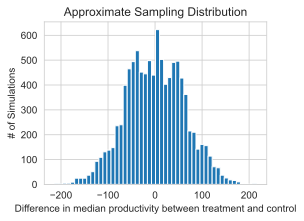

In [142]:
plt.hist(median_diff_simulation, bins=50)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Difference in median productivity between treatment and control')

In [133]:
len([elem for elem in median_diff_simulation if elem <= -212]) / 10000

0.0001

## A test based on ranks

Back before the days of cheap computers, it was often not practical to estimate p-values by simulation.  Statisticians who wanted to do randomization tests found a clever way around the problem.  Their solution was based on the fact that if your population consists of consecutive integers, like {1, 2, 3,...,  n} there is a theoretical analysis that gives a workable approximation to p-values.   Of course most populations don't consist of consecutive integers, but you can force them to if you replace the actual data values with their ranks:  order the values from smallest to largest, assign rank 1 to the smallest, rank 2 to the next smallest, etc.  Once you've assigned ranks, you can do a two-sample permutation test on the ranks.

Statistic: Rank sum. We pool all of the data and assign them ranks from 1 for the smallest value to 200 for the largest value. Like with the previous statistics, under the null, the difference in the sum of the ranks for productivity for the two groups is due to the chance process in group assignment.

In [134]:
from scipy.stats import rankdata

In [135]:
x = wiki[['posttreatmentproductivity']].to_numpy()
ranks = rankdata(wiki['posttreatmentproductivity'], 'average')

In [136]:
sum(ranks[100:])

11368.0

In [137]:
def rank_sum(ranks, n):
    rng.shuffle(ranks)
    return np.sum(ranks[n:])         

In [138]:
rank_sum_simulation = [rank_sum(ranks, 100) for _ in range(100000)] 

Text(0.5, 0, 'Rank Sum for treatment')

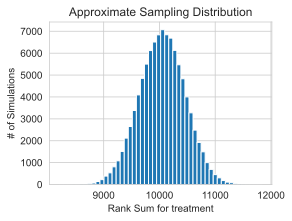

In [140]:
plt.hist(rank_sum_simulation, bins=50)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Rank Sum for treatment')

In [141]:
len([elem for elem in rank_sum_simulation if elem >= 11368]) / 100000

0.00059